In [1]:
# lets do simulations / images with a crowded field, on the optimised pupil
# probably just calculate fisher info of everything
# / cramer rao bounds as a multiple of airy disk cramer raos

# Core jax
import jax
# from jax.config import config
jax.config.update("jax_enable_x64", True)

import jax.numpy as np
import jax.random as jr

# Optimisation
import zodiax as zdx
import optax

# Optics
import dLux as dl
import dLux.utils as dlu
import dLuxToliman as dlT

# Plotting/visualisation
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from dLuxToliman import ApplyBasisCLIMB, TolimanOpticalSystem

# gonna have to define my own log likelihoods which are analytic contiuations???

from jax.scipy.special import gammaln, xlogy

def poisson_loglike_gamma(k, mu):
    # analytic continuation using gammaln(k+1)
    k = np.asarray(k)
    mu = np.asarray(mu)
    valid = (k >= 0) & np.isfinite(k) & (mu > 0) & np.isfinite(mu)
    logp = xlogy(k, mu) - mu - gammaln(k + 1.0)
    return np.where(valid, logp, -np.inf)

def poisson_loglike_unnormalized(k, mu):
    # returns k*log(mu) - mu  (no normalization constant)
    return xlogy(k, mu) - mu

# define the likelihood function:
def poiss_loglike(pytree, data) -> float:
    """
    Poissonian log likelihood of the pytree given the data. Assumes the pytree
    has a .model() function.

    Parameters
    ----------
    pytree : Base
        Pytree with a .model() function.
    data : Array
        Data to compare the model to.

    Returns
    -------
    log_likelihood : Array
        Log likelihood of the pytree given the data.
    """
    return poisson_loglike_gamma(pytree.model(), data).sum()

plt.rcParams["image.origin"] = 'lower'
plt.rcParams["image.cmap"] = 'inferno'

from pathlib import Path

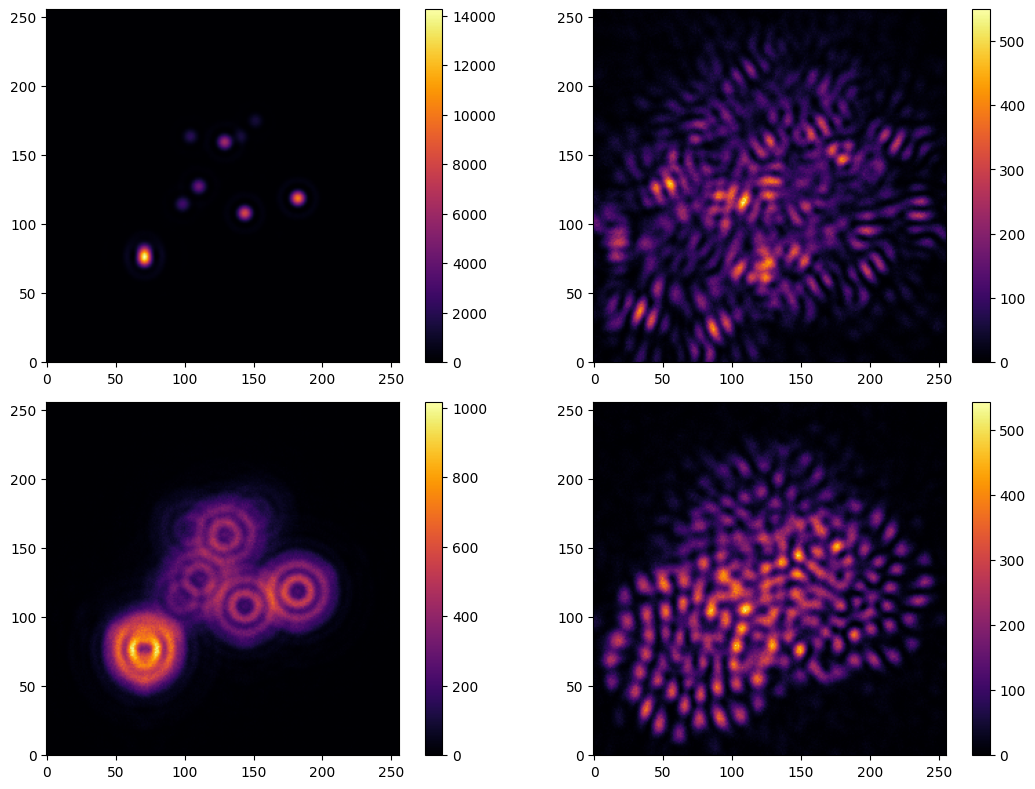

In [64]:
# jax random key
key = jr.PRNGKey(9)

wf_npix = 256 
diameter = 1 # 1 meter diameter

wavelength = 1e-6 # 1 micron wavelength

# This is to what degree we undersample Nyquist
nyquist_factor = 1
psf_npix = 64 / nyquist_factor
psf_pixel_scale = nyquist_factor * dlu.rad2arcsec(wavelength/(2*diameter))
oversample = nyquist_factor * 4 # sample at 4x nyquist originally

# number of sources, random positions
# let's go with the middle 75% of the psf
image_fac = 0.5
max_dist = dlu.arcsec2rad(psf_pixel_scale*psf_npix/2*image_fac)

n_sources = 10
positions = jr.uniform(key, (n_sources,2), minval = -max_dist, maxval = max_dist)

# uniform distribution of fluxes in logspace
log_fluxes = jr.uniform(key, (n_sources,) ,minval=5, maxval=6)
fluxes = 10**(log_fluxes)

# I wish I could just use the following, but it breaks with the fisher matrix (position inference)
# sources = dl.PointSources(np.array([wavelength]), positions, fluxes)
sources = []
for i in range(n_sources):
    source = dl.PointSource(np.array([wavelength]), positions[i], fluxes[i])
    sources.append(source)

scene = dl.Scene(sources)

# import the particular pupil
pupil = np.load("../xk8/05sne.npy")

aperture_layer = dlT.TolimanApertureLayer(wf_npix)

pupil_layer = dl.AberratedLayer(phase = pupil)

layers = [
    (
        'aperture',
        aperture_layer
    ),
    (
        'pupil',
        pupil_layer
    )
]

optics = dl.AngularOpticalSystem(wf_npix, diameter, layers, psf_npix, psf_pixel_scale, oversample)

# optional detector
detector_layers = [
    (
        'downsample',
        dl.detector_layers.Downsample(1)
    )
]
detector = dl.LayeredDetector(detector_layers)

telescope = dl.Telescope(optics, scene, detector)

image = telescope.model()

# now for the airy disk:
layers_airy = [
    (
        'aperture',
        aperture_layer
    )
]

optics_airy = dl.AngularOpticalSystem(wf_npix, diameter, layers_airy, psf_npix, psf_pixel_scale, oversample)

telescope_airy = dl.Telescope(optics_airy, scene, detector)

image_airy = telescope_airy.model()

# zernike defocuser
diffuser = 1.7*dlu.zernike(4, dlu.pixel_coords(wf_npix*diameter, diameter), diameter)

diffuser_layer = dl.AberratedLayer(phase=diffuser)

layers_diffuser = [
    (
        'aperture',
        aperture_layer
    ),
    (
        'diffuser',
        diffuser_layer
    )
]

optics_diffuse = dl.AngularOpticalSystem(wf_npix, diameter, layers_diffuser, psf_npix, psf_pixel_scale, oversample)
telescope_diffuse = dl.Telescope(optics_diffuse, scene, detector)
image_diffuse = telescope_diffuse.model()

# toliman pupil
layers_tol = [
    (
        'aperture',
        aperture_layer
    ),
    (
        'pupil',
        dlT.TolimanPupilLayer(wf_npix)
    )
]

optics_tol = dl.AngularOpticalSystem(wf_npix, diameter, layers_tol, psf_npix, psf_pixel_scale, oversample)
telescope_tol = dl.Telescope(optics_tol, scene, detector)
image_tol = telescope_tol.model()

plt.figure(figsize=(11,8))
plt.subplot(2,2,1)
plt.imshow(jr.poisson(key, image_airy)**1)
plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(jr.poisson(key,image)**1)
plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(jr.poisson(key,image_diffuse)**1)
plt.colorbar()

plt.subplot(2,2,4)
plt.imshow(jr.poisson(key,image_tol)**1)
plt.colorbar()

plt.tight_layout()
plt.show()

In [65]:
src_keys = sorted(telescope_airy.source.sources.keys(),
                  key=lambda k: int(k.split('_')[-1]))

# 2) Build parameter paths for all positions
marginal_params = [f"source.sources.{k}.position" for k in src_keys]

print(marginal_params)

['source.sources.PointSource_0.position', 'source.sources.PointSource_1.position', 'source.sources.PointSource_2.position', 'source.sources.PointSource_3.position', 'source.sources.PointSource_4.position', 'source.sources.PointSource_5.position', 'source.sources.PointSource_6.position', 'source.sources.PointSource_7.position', 'source.sources.PointSource_8.position', 'source.sources.PointSource_9.position']


In [66]:
cov_airy = zdx.covariance_matrix(telescope_airy, marginal_params, poiss_loglike, data=image_airy)
cov_pupil = zdx.covariance_matrix(telescope, marginal_params, poiss_loglike, data=image)
cov_diffuse = zdx.covariance_matrix(telescope_diffuse, marginal_params, poiss_loglike, data=image_diffuse)
cov_tol = zdx.covariance_matrix(telescope_tol, marginal_params, poiss_loglike, data=image_tol)

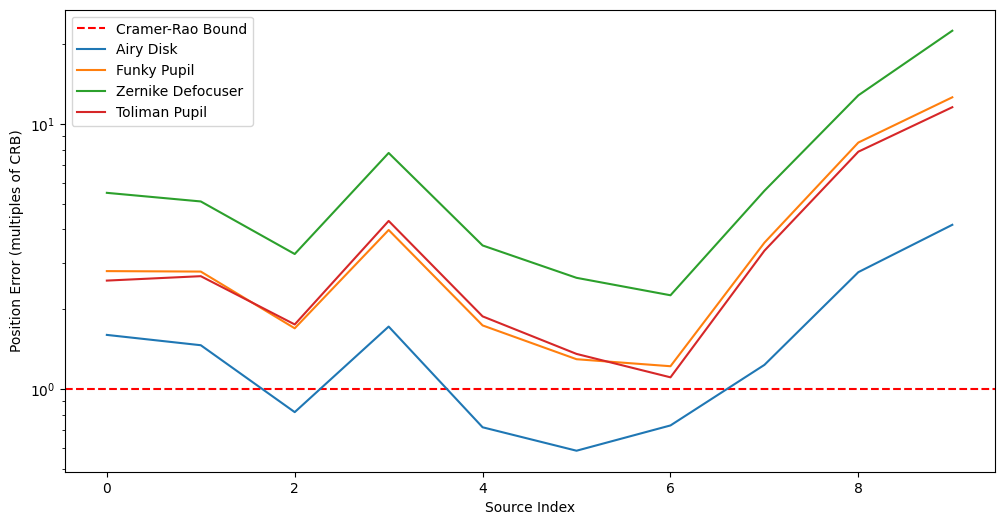

In [67]:
# this is root mean square radial extent
def crb_pos(wavelength, diameter, flux):
    crb = ( np.sqrt(2)/(np.pi*np.sqrt(flux)) ) * (wavelength/diameter)
    return crb

pos_errors_airy = []
for i in range(n_sources):
    
    rms_error = np.sqrt(cov_airy[i,i] + cov_airy[i+1,i+1])

    crb = crb_pos(wavelength, diameter, fluxes[i])

    pos_errors_airy.append(rms_error/crb)

pos_errors = []
for i in range(n_sources):
    
    rms_error = np.sqrt(cov_pupil[i,i] + cov_pupil[i+1,i+1])

    crb = crb_pos(wavelength, diameter, fluxes[i])

    pos_errors.append(rms_error/crb)

pos_errors_diffuse = []
for i in range(n_sources):
    
    rms_error = np.sqrt(cov_diffuse[i,i] + cov_diffuse[i+1,i+1])

    crb = crb_pos(wavelength, diameter, fluxes[i])

    pos_errors_diffuse.append(rms_error/crb)

pos_errors_tol = []
for i in range(n_sources):
    
    rms_error = np.sqrt(cov_tol[i,i] + cov_tol[i+1,i+1])

    crb = crb_pos(wavelength, diameter, fluxes[i])

    pos_errors_tol.append(rms_error/crb)



plt.figure(figsize=(12,6))
plt.axhline(1,ls='--',color='red',label='Cramer-Rao Bound')
plt.plot(pos_errors_airy, label='Airy Disk')
plt.plot(pos_errors, label='Funky Pupil')
plt.plot(pos_errors_diffuse, label='Zernike Defocuser')
plt.plot(pos_errors_tol, label='Toliman Pupil')
plt.xlabel('Source Index')
plt.ylabel('Position Error (multiples of CRB)')
plt.yscale('log')
plt.legend()
plt.show()


In [68]:
pos_errors_airy_total.append(pos_errors_airy)
pos_errors_total.append(pos_errors)
pos_errors_diffuse_total.append(pos_errors_diffuse)

In [69]:
pos_errors_airy_total_array = np.array(pos_errors_airy_total)
pos_errors_total_array = np.array(pos_errors_total)
pos_errors_diffuse_total_array = np.array(pos_errors_diffuse_total)

In [70]:
np.save('airypos',pos_errors_airy_total_array)
np.save('pupilpos', pos_errors_total_array)
np.save('defocpos', pos_errors_diffuse_total_array)